In [1]:
NOTE = 'XGBoostベクトルは除外'
notebook_name = '038'

In [2]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

038_submission.csv 038


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])
# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(12, 384, 107)

In [6]:
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [7]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [8]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [9]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [10]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [11]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    # feature transformation
    ## categorical features
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    ## descrete features
    X_train_discrete = X_train.copy()[discrete_features]
    X_valid_discrete = X_valid.copy()[discrete_features]
    X_test_discrete = test.copy()[discrete_features]
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = pd.concat([X_train_categorical,
                                     X_train_discrete,
#                                      X_train_vector
                                    ],
                                    axis=1)
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = pd.concat([X_valid_categorical,
                                     X_valid_discrete,
#                                      X_valid_vector
                                    ],
                                    axis=1)
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = pd.concat([X_test_categorical,
                                    X_test_discrete,
#                                     X_test_vector
                                   ],
                                   axis=1)
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
    class_weight = compute_class_weight('balanced',
                                        classes=np.sort(train.y.unique()),
                                        y=y_train.values)
    class_weight = dict(
        zip(
            np.sort(train.y.unique()),
            class_weight
        )
    )
    sample_weight = y_train.map(class_weight)
    assert(sample_weight.isnull().sum() == 0)
#     sample_weight = None
    # classification
    clf = XGBClassifier(random_state=SEED,
                        n_jobs=-1,
                        n_estimators=300,
                        learning_rate=0.01)
    clf.fit(X_train_transformed,
            y_train.values,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
            'index': train_idx,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
            'index': valid_idx,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 1)**********
[[1662 1093  557  546  476  300   24  408]
 [ 464 1888  308  348  288  168   25  257]
 [ 272  360  803  348  269  145   16  180]
 [ 172  217  112  848  158   83   10  109]
 [  25   25   18   32  379   25    2   34]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[308 329 174 163 122  71  11  89]
 [156 346  96 114  71  60   7  86]
 [ 97 113  95 107  99  41   0  47]
 [ 56  68  77 116  48  31   1  30]
 [ 19  25  24  20  28   9   0  10]
 [  8   4   6   6   7   4   0   2]
 [  2   0   1   0   0   0   0   0]
 [  0   8   5   3   3   1   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 2)**********
[[1671 1093  550  578  431  321   39  383]
 [ 494 1820  317  349  267  213   44  242]
 [ 285  354  835  354  242  146   15  162]
 [ 167  227  137  857  132   70   13  106]
 [  29   32   20   29  384   20    5   21]
 [   0    2    1    0    0  144    0    3]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 2)**********
[[300 315 164 165 120  98  17  88]
 [188 332  97 112  74  43   8  82]
 [ 85 119 106 118  69  37   5  60]
 [ 71  74  77 110  40  23   4  28]
 [ 20  18  34  24  18   9   0  12]
 [  4   8   5   4   9   3   0   4]
 [  0   1   0   0   1   0   0   0]
 [  8   2   3   2   2   3   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 3)**********
[[1648 1116  556  594  397  329   44  382]
 [ 444 1863  322  389  233  199   32  264]
 [ 302  364  777  383  216  153   18  181]
 [ 168  202  132  917   90   81   12  106]
 [  35   36   26   36  339   32    3   33]
 [   0    1    0    0    1  146    0    2]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 3)**********
[[334 311 152 165  99  79  15 112]
 [191 365  77 114  49  56  12  72]
 [106  98 105 140  60  31   2  56]
 [ 80  74  65 112  42  21   3  31]
 [ 24  26  23  23  15   9   2  13]
 [  5  11   7   3   4   2   0   5]
 [  1   0   0   0   0   1   0   0]
 [  4   4   4   2   2   2   1  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 4)**********
[[1683 1105  582  572  404  286   43  392]
 [ 483 1830  333  355  267  168   45  264]
 [ 275  354  849  335  231  136   17  197]
 [ 158  204  155  884  136   64   15   93]
 [  27   42   17   20  384   18    3   29]
 [   1    1    0    0    0  141    0    6]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 4)**********
[[311 329 165 145 127  76   9 104]
 [151 360 126 108  67  43   8  74]
 [ 91 114 118 112  91  33   2  37]
 [ 53  69  87  99  54  26   5  34]
 [ 27  17  27  20  17  11   2  14]
 [  8   6   3   5  10   4   1   1]
 [  1   0   0   0   1   0   0   0]
 [  4   8   4   1   4   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 5)**********
[[1678 1066  545  573  405  357   38  405]
 [ 474 1834  295  339  250  244   32  277]
 [ 286  372  811  318  225  167   16  199]
 [ 163  202  128  854  127  113   10  112]
 [  23   30   20   24  372   41    1   29]
 [   0    1    1    0    0  143    0    4]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 5)**********
[[271 343 146 156 118 112   9 111]
 [168 375  87  91  66  67   7  76]
 [ 85  92 105 115  83  53   4  61]
 [ 68  84  76  89  40  35   6  29]
 [ 19  22  17  26  26   8   0  17]
 [  5   7   2   5   8   3   0   8]
 [  0   0   0   0   1   1   0   0]
 [  5   3   3   2   1   3   0  

In [12]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.342117,0.158056
std,0.003196,0.003014
min,0.338985,0.153485
25%,0.339243,0.157234
50%,0.341442,0.158025
75%,0.345354,0.160599
max,0.345561,0.160938


In [13]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,index,train,fold
0,0,0,1,0,0,1
1,1,1,1,1,0,1
2,2,0,2,2,0,1
3,3,2,2,3,0,1
4,4,4,4,4,0,1
...,...,...,...,...,...,...
17126,9690,0,1,17126,1,5
17129,9693,1,2,17129,1,5
17130,16833,1,1,17130,1,5
17133,9762,1,1,17133,1,5


In [14]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.097639,0.138273,0.193327,0.188687,0.203219,0.109708,0.034345,0.034802,27446,1
1,0.128317,0.097856,0.214320,0.283843,0.168446,0.052651,0.025651,0.028916,113,1
2,0.238339,0.285253,0.191771,0.108377,0.085691,0.042542,0.020726,0.027302,4479,1
3,0.235395,0.231132,0.168754,0.169008,0.092383,0.052115,0.021448,0.029764,29080,1
4,0.232836,0.150190,0.197800,0.152269,0.138529,0.064391,0.027280,0.036705,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.149513,0.429471,0.127513,0.160637,0.031120,0.048614,0.026493,0.026639,24272,5
33804,0.099699,0.280163,0.261096,0.188821,0.058645,0.056080,0.027672,0.027824,29106,5
33805,0.098138,0.294234,0.266557,0.173808,0.057433,0.055202,0.027239,0.027388,20679,5
33806,0.236080,0.283758,0.218837,0.120494,0.046065,0.047631,0.023503,0.023632,25901,5


In [15]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.585644,1.306785,0.932663,0.783784,0.901101,0.232389,0.128691,0.128943
1,1,1.243346,1.388276,0.677656,0.680617,0.252861,0.483284,0.124871,0.149089
2,2,0.262298,0.507854,1.111554,1.812989,0.518575,0.317002,0.161869,0.307860
3,3,1.040462,1.009047,0.703755,1.129608,0.567351,0.296255,0.126629,0.126893
4,4,1.264039,1.330040,0.536047,0.662805,0.683592,0.266472,0.115880,0.141125
...,...,...,...,...,...,...,...,...,...
33803,33803,1.507308,0.537049,0.558759,0.478973,0.863022,0.535397,0.121572,0.397920
33804,33804,1.206403,1.140089,0.563700,1.173484,0.327079,0.316463,0.118741,0.154040
33805,33805,1.079830,1.209836,0.559018,1.036660,0.460944,0.383929,0.115628,0.154155
33806,33806,0.753775,0.796488,1.105730,1.293197,0.234927,0.471283,0.172120,0.172479


In [16]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,3
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,1
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.172829
1    0.464003
2    0.050580
3    0.195309
4    0.049870
5    0.018161
6    0.005650
7    0.043599
Name: y, dtype: float64

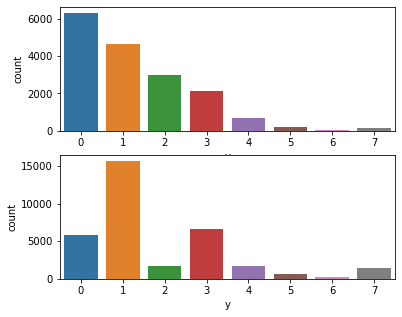

In [17]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [18]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [19]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.34211697538209007, 0.15805610284792096)

In [20]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"038_submission.csv","Stratified-Kfold(K=5)","0.342117","0.158056","","XGBoostベクトルは除外"


In [21]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 11.1 s


In [22]:
imp_df

,feature,importance,fold
0,batterID,0.004332,1
1,pitcherID,0.007952,1
2,Match,0.007686,1
3,isBatterHandLeft,0.002879,1
4,isPitcherHandLeft,0.008648,1
...,...,...,...
114,distDirV,0.014202,5
115,distDirW,0.005988,5
116,distDirX,0.006861,5
117,distDirY,0.008756,5


In [23]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [24]:
coef_df

""
